# Laboratorio 8 Clasificación de Malware con DL
## Security Data Science
### Universidad del valle de Guatemala

Abner Ivan Garcia - 21285

Oscar Esteba Donis - 21610

In [44]:
!pip3 install keras
!pip3 install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Obteniendo Librerias

In [45]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import os
import pandas as pd
import seaborn as sns

#### 1. En el preprocesamiento debe mostrar cuantos ejemplares hay por cada familia. En base a estos datos debe determinar si considera pertinente prescindir de ejemplares que tengan pocas observaciones.

In [46]:
path = './malimg_paper_dataset_imgs/'

Total number of malware families: 25
Total number of samples: 9339

Samples per family:


Family  Count
2        Allaple.A   2949
3        Allaple.L   1591
24         Yuner.A    800
11   Instantaccess    431
22           VB.AT    408
10        Fakerean    381
12      Lolyda.AA1    213
6      C2LOP.gen!g    200
4    Alueron.gen!J    198
13      Lolyda.AA2    184
8   Dialplatform.B    177
9        Dontovo.A    162
15       Lolyda.AT    159
18        Rbot!gen    158
7          C2LOP.P    146
17   Obfuscator.AD    142
16     Malex.gen!J    136
21   Swizzor.gen!I    132
20   Swizzor.gen!E    128
14      Lolyda.AA3    123
0        Adialer.C    122
1        Agent.FYI    116
5        Autorun.K    106
23      Wintrim.BX     97
19      Skintrim.N     80

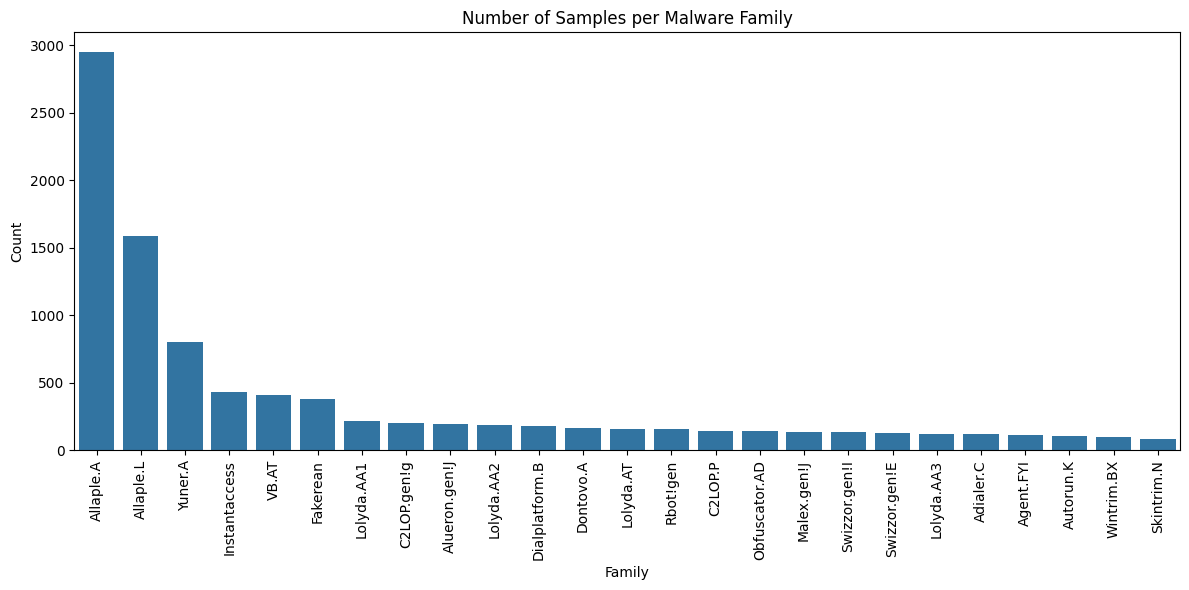

In [47]:
# Obtenemos la lista de familias de malware
malware_families = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Contamos el número de muestras por familia
family_counts = {}
for family in malware_families:
    family_path = os.path.join(path, family)
    count = len([f for f in os.listdir(family_path) if os.path.isfile(os.path.join(family_path, f))])
    family_counts[family] = count

# creamos un DataFrame para visualizar los datos
df_counts = pd.DataFrame(list(family_counts.items()), columns=['Family', 'Count'])
df_counts = df_counts.sort_values(by='Count', ascending=False)

# mostramos la información
print(f"Total number of malware families: {len(malware_families)}")
print(f"Total number of samples: {sum(family_counts.values())}")
print("\nSamples per family:")
display(df_counts)

# Visualizamos la distribución de las muestras por familia
plt.figure(figsize=(12, 6))
sns.barplot(x='Family', y='Count', data=df_counts)
plt.title('Number of Samples per Malware Family')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [48]:
# hacemos un shape 
df_counts.shape

(25, 2)

#### 2. Plotee algunas imágenes de los ejemplos de malware.

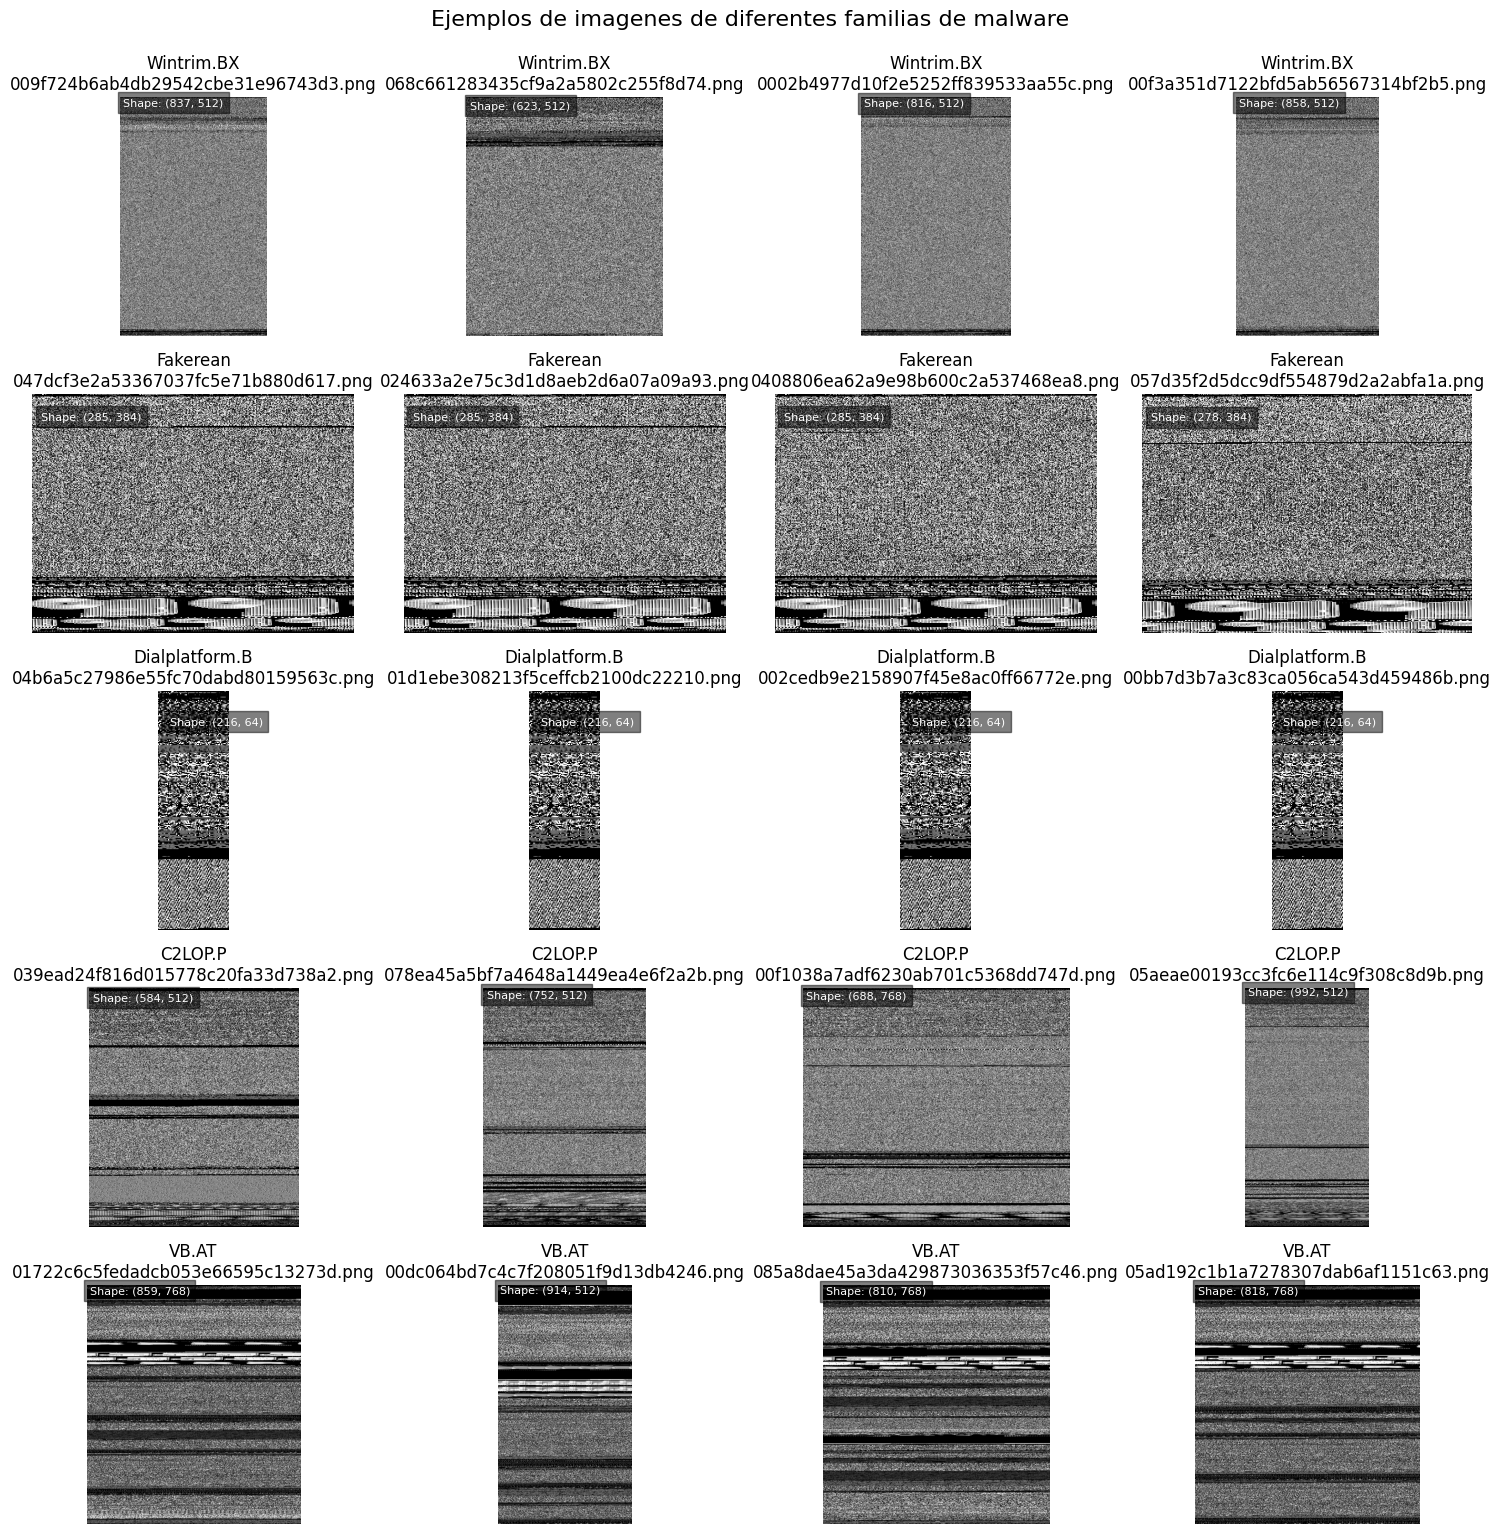

Examples from the smallest families: Skintrim.N, Wintrim.BX, Autorun.K


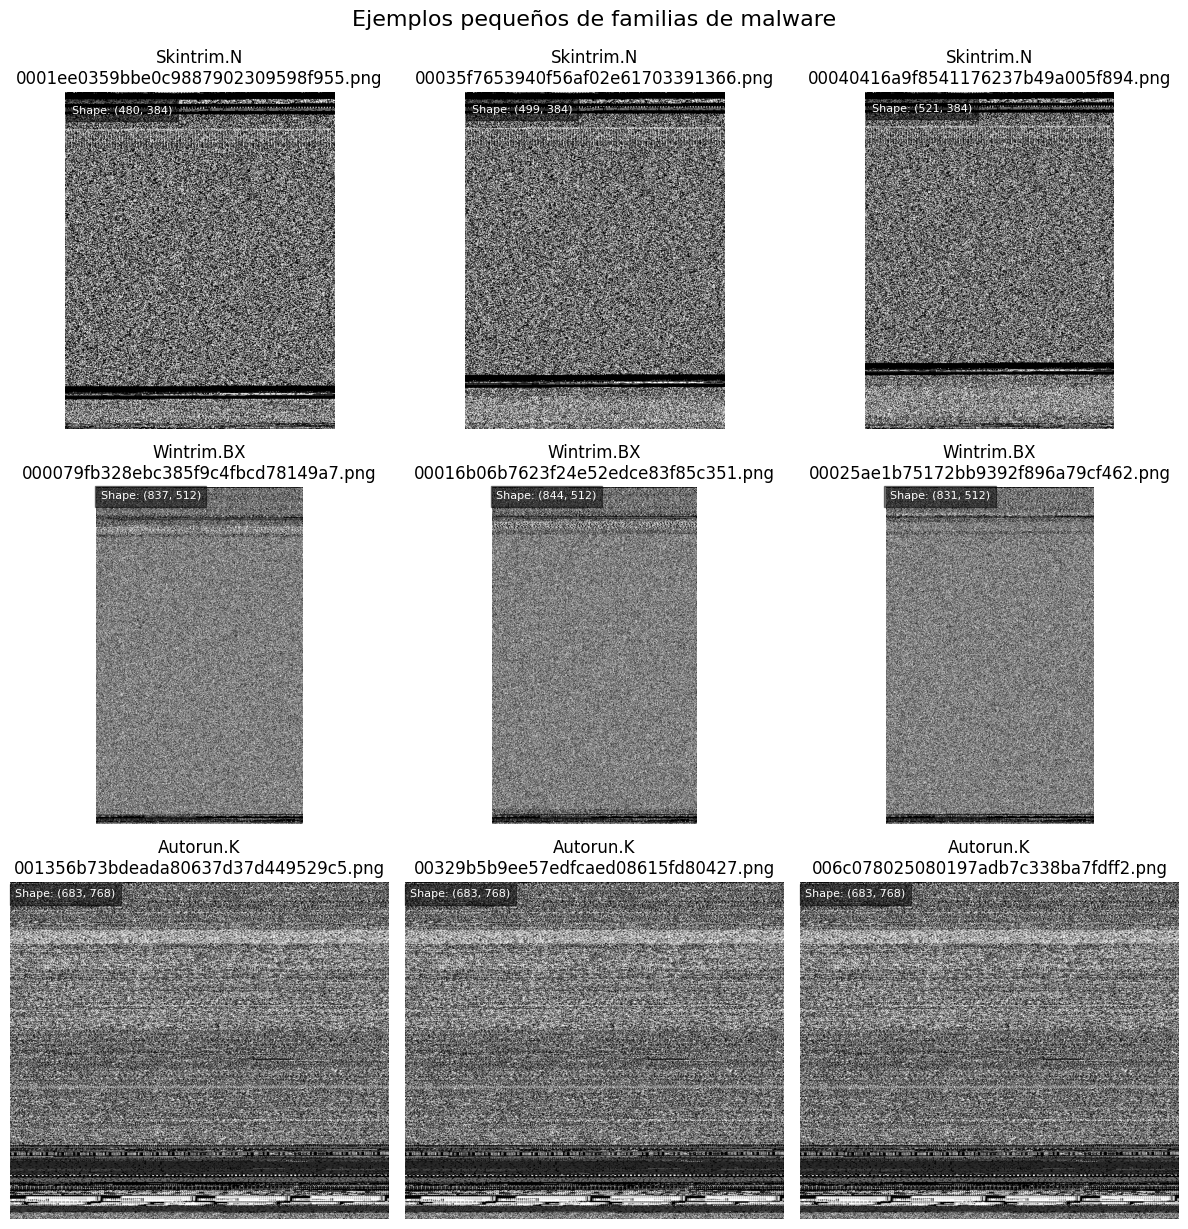

In [49]:
# función para cargar las imágenes y etiquetas
def plot_malware_examples(num_families=5, examples_per_family=3):
    # seleccionamos aleatoriamente un número de familias
    sample_families = random.sample(malware_families, min(num_families, len(malware_families)))
    
    # creamos una figura para mostrar las imágenes
    fig, axes = plt.subplots(len(sample_families), examples_per_family, figsize=(15, 3*len(sample_families)))
    
    # ajustamos el tamaño de los ejes si solo hay una familia
    if len(sample_families) == 1:
        axes = axes.reshape(1, -1)
    
    # iteramos sobre las familias seleccionadas y sus archivos 
    for i, family in enumerate(sample_families):
        family_path = os.path.join(path, family)
        files = [f for f in os.listdir(family_path) if os.path.isfile(os.path.join(family_path, f))]
        
        # muestra un número aleatorio de archivos de cada familia
        sample_files = random.sample(files, min(examples_per_family, len(files)))
        
        # iteramos sobre los archivos seleccionados y los mostramos en la figura 
        for j, file in enumerate(sample_files):
            img_path = os.path.join(family_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # ajustamos el tamaño de la imagen
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f"{family}\n{file}")
            axes[i, j].axis('off')
            
            # agregamos información adicional sobre la imagen
            axes[i, j].text(10, 30, f"Shape: {img.shape}", color='white', fontsize=8,
                           bbox=dict(facecolor='black', alpha=0.5))
    
    plt.tight_layout()
    plt.suptitle("Ejemplos de imagenes de diferentes familias de malware", y=1.02, fontsize=16)
    plt.show()

# Mostramos ejemplos de malware de diferentes familias
plot_malware_examples(num_families=5, examples_per_family=4)

# Mostramos ejemplos de las familias más pequeñas 
smallest_families = df_counts.sort_values('Count').head(3)['Family'].tolist()
print(f"Examples from the smallest families: {', '.join(smallest_families)}")

# Aqui vamos a mostrar las imágenes de las familias más pequeñas
fig, axes = plt.subplots(len(smallest_families), 3, figsize=(12, 4*len(smallest_families)))
if len(smallest_families) == 1:
    axes = axes.reshape(1, -1)
# iteramos sobre las familias más pequeñas y sus archivos
for i, family in enumerate(smallest_families):
    family_path = os.path.join(path, family)
    files = [f for f in os.listdir(family_path) if os.path.isfile(os.path.join(family_path, f))]
    sample_files = files[:3] if len(files) >= 3 else files
    
    for j, file in enumerate(sample_files):
        if j < 3:  # Aseguramos que no exceda el número de columnas
            img_path = os.path.join(family_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].set_title(f"{family}\n{file}")
            axes[i, j].axis('off')
            axes[i, j].text(10, 30, f"Shape: {img.shape}", color='white', fontsize=8,
                           bbox=dict(facecolor='black', alpha=0.5))

plt.tight_layout()
plt.suptitle("Ejemplos pequeños de familias de malware", y=1.02, fontsize=16)
plt.show()

#### 3. Divida el dataset en un 70% entrenamiento y un 30% de pruebas.

In [54]:
# Normalizamos las datos
def normalize_image(image):
    # Normalizamos la imagen a un rango de 0 a 1
    return image / 255.0

# división de los datos en conjuntos de entrenamiento y prueba 70% entrenamiento y un 30% de pruebas
def load_data(path, test_size=0.3, random_state=42):
    images = []
    labels = []
    
    for family in malware_families:
        family_path = os.path.join(path, family)
        files = [f for f in os.listdir(family_path) if os.path.isfile(os.path.join(family_path, f))]
        
        for file in files:
            img_path = os.path.join(family_path, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Redimensionamos la imagen
            img = normalize_image(img)  # Normalizamos la imagen
            
            images.append(img)
            labels.append(family)
    
    images = np.array(images)
    labels = np.array(labels)
    
    # Dividimos los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test


#### 4. Utilizando Keras y Tensorflow construya una red neuronal con las capas, funciones de activación y el optimizador que considere conveniente.

In [57]:
# Definicion del modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(25, activation='softmax'))  # 25 clases de malware

# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### 5. Muestre el resumen del modelo.

In [58]:
# mostrar el resumen del modelo
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,801 (6.21 MB)

 Trainable params: 1,627,801 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

#### 6. Entrene el modelo con el número de épocas que considere conveniente.

In [ ]:
# Obtener los datos de entrenamiento y prueba del paso 3
X_train, X_test, y_train, y_test = load_data(path)
X_train = np.expand_dims(X_train, axis=-1)  
X_test = np.expand_dims(X_test, axis=-1)  
y_train = LabelBinarizer().fit_transform(y_train)  
y_test = LabelBinarizer().fit_transform(y_test)  

# Entrenamos el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.4351 - loss: 2.0221 - val_accuracy: 0.8437 - val_loss: 0.5330
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.8370 - loss: 0.5673 - val_accuracy: 0.9236 - val_loss: 0.2494
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8931 - loss: 0.3678 - val_accuracy: 0.9536 - val_loss: 0.1503
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9239 - loss: 0.2496 - val_accuracy: 0.9643 - val_loss: 0.1180
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.9343 - loss: 0.2080 - val_accuracy: 0.9615 - val_loss: 0.1174
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9394 - loss: 0.1863 - val_accuracy: 0.9661 - val_loss: 0.1061
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9434 - loss: 0.1772 - val_accuracy: 0.9647 - val_loss: 0.1089
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9482 - loss: 0.1621 - 

#### 7. Muestre las métricas de su modelo.

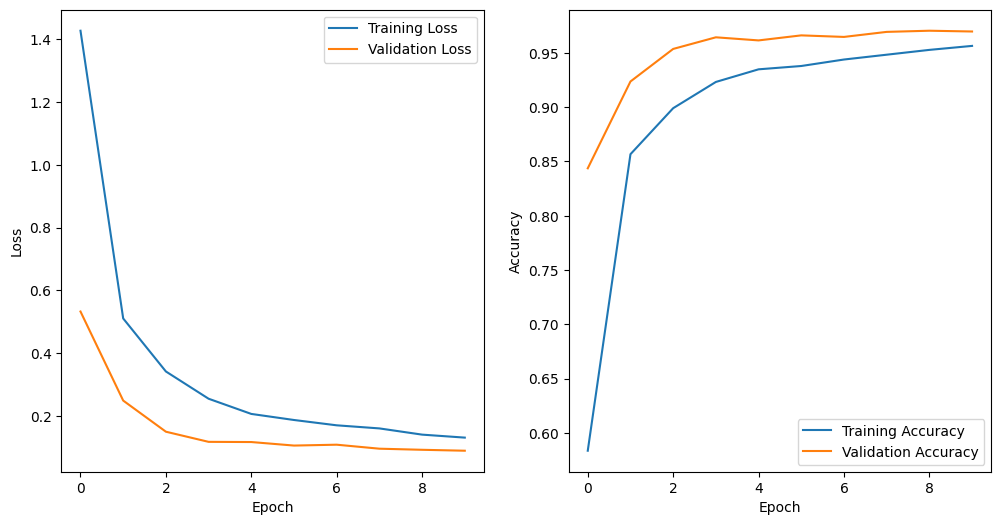

In [63]:
# Visualización del proceso de entrenamiento
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 8. Evalúe el modelo con el dataset de pruebas y muestre las métricas obtenidas. Discuta los resultados obtenidos.

In [64]:
# Evaluación del modelo con el dataset de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
print()

# Metricas obtenidas
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {accuracy:.4f}")
print(f"Recall: {accuracy:.4f}")
print(f"F1 Score: {accuracy:.4f}")


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9747 - loss: 0.0753
Loss: 0.0897, Accuracy: 0.9697

Loss: 0.0897
Accuracy: 0.9697
Precision: 0.9697
Recall: 0.9697
F1 Score: 0.9697


R// 